# Constrained MILP Clustering - USA Single site

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

from IPython.display import display

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

input_path = Path('../US_building_energy_demand_prep/data/US_single_site_preprocessed')
output_path = Path('results')
graphs_path = Path('results')

### Import data

In [2]:
def get_input_prefix(state, n_households):
    return '{}_{}_'.format(state, n_households)

In [3]:
def load_preprocessed_data(state, n_households, year=2015, properties=['cooling', 'heating', 'electricity']):
    
    start = pd.datetime(year,1,1)
    end   = pd.datetime(year+1,1,1)
    index = pd.DatetimeIndex(start=start, end=end, freq='h')[:-1]

    prefix = get_input_prefix(state, n_households)
    
    d = {}
    
    for prop in properties:
        _filename = prefix + prop + '.csv'
        d[prop] = pd.read_csv(input_path / _filename, header=None, squeeze=True)

    df = pd.concat(d.values(), axis=1, keys=d.keys())
    df.set_index(index, inplace=True)
    
    return df

In [4]:
state = 'NY'
n_households = 45
year = 2015
properties = ['cooling', 'heating', 'electricity']

df = load_preprocessed_data(state, n_households, year, properties)

### import distance data

In [5]:
def load_distance_data(state, n_households):
    
    prefix = get_input_prefix(state, n_households)
    _filename = prefix + 'distance.csv'
    
    dist = np.loadtxt(input_path / _filename, delimiter=',')
    n_days = dist.shape[0]
    
    dist_df = pd.DataFrame(dist, index=np.arange(n_days)+1, columns=np.arange(n_days)+1)
    
    return dist_df, n_days

In [6]:
dist_df, n_days = load_distance_data(state, n_households)

### Cluster

In [7]:
import k_medoids_constrained as clustering
import clustering_utils as utils

from pyomo import environ as pe

In [8]:
daily_df = df.groupby(pd.Grouper(freq='d')).agg(['sum', 'max']).rename_axis(['property', 'metric'], axis=1)
daily_df.index = daily_df.index.dayofyear
daily_df = daily_df.rename_axis('day').stack(level='property').reorder_levels(['property', 'day'])

In [9]:
_n_days = 365

_input_df = daily_df[daily_df.index.get_level_values('day') <= _n_days]

_dist_df = dist_df.loc[:_n_days, :_n_days]

In [10]:
n_clusters = 6
n_extreme_days = 6
rel_tol = 0.05
rel_tol_d = {prop:rel_tol for prop in df.columns}
min_peak_share = 0.95
min_peak_share_d = {prop:min_peak_share for prop in properties}

data = dict(
    n_days = _n_days,
    n_clusters = n_clusters,
    n_extreme_days = n_extreme_days,
    distance = _dist_df.stack().to_dict(),
    Properties = df.columns.tolist(),
    x_daily_tot = _input_df['sum'].to_dict(),
    x_daily_max = _input_df['max'].to_dict(),
    x_max = _input_df['max'].max(level='property').to_dict(),
    rel_tol = rel_tol_d,
    min_peak_share = min_peak_share_d
)

data = utils.get_pyomo_input_dictionary(data)

In [11]:
m = clustering.create_model(preserve_total_values=True, preserve_peak_values=False)

cm = m.create_instance(data=data)

In [12]:
with pe.SolverFactory("cplex") as opt:

    solver_manager = pe.SolverManagerFactory('neos')

    results = solver_manager.solve(cm, opt=opt)

cm.solutions.load_from(results)

Job 6090121 submitted to NEOS, password='SZWrCkcY'
Check the following URL for progress report :
https://www.neos-server.org/neos/cgi-bin/nph-neos-solver.cgi?admin=results&jobnumber=6090121&pass=SZWrCkcY
Job 6090121 dispatched
password: SZWrCkcY
---------- Begin Solver Output -----------


### Extract results

In [13]:
y = pd.Series(cm.y.get_values())
z = pd.Series(cm.z.get_values()).unstack()

# get dictionary like k:representative_day
clusters_repr_d = dict(enumerate(y.index[y>0]))

# get dictionary like k: [list of represented days]
clusters_members_d = {k: z.index[z.loc[rep,:] > 0].tolist() 
                      for k, rep in clusters_repr_d.items()}

# get dictionary like d:k -- value is n_clusters if the day is extreme
day_to_cluster_d = dict(zip(np.arange(n_days)+1, np.ones(n_days)*n_clusters))
day_to_cluster_d.update({d:k for k, l in clusters_members_d.items() for d in l})

# get series like day_of_year:k
labeled = pd.Series(day_to_cluster_d).sort_index()

### save results

In [14]:
def get_output_prefix(state, n_households, n_clusters, n_extreme_days):
    
    prefix = get_input_prefix(state, n_households)
    output_prefix = prefix + '{}k_{}ed_'.format(n_clusters, n_extreme_days)
    
    return output_prefix

In [15]:
output_prefix = get_output_prefix(state, n_households, n_clusters, n_extreme_days)

y.to_csv(output_path / (output_prefix + 'y.csv'), index=True)
z.to_csv(output_path / (output_prefix + 'z.csv'), index=True)

### get weekly calendar

In [16]:
# get dict like d:repr
day_to_repr_d = {d: clusters_repr_d.get(k, d) for d, k in day_to_cluster_d.items()}

start = pd.datetime(year, 1, 1)
end   = pd.datetime(year+1, 1, 1)
index = pd.DatetimeIndex(start=start, end=end, freq='d', closed='left')

labeled = pd.Series(labeled.values, index=index, dtype=int)

weekly_df = labeled.rename('cluster').to_frame() \
    .assign(dayofweek=labeled.index.weekday, week=labeled.index.weekofyear) \
    .set_index(['dayofweek', 'week']).cluster.unstack(level=0)

representative_ts = pd.Series(y.values, index=index, dtype=int)

weekly_repr_df = representative_ts.rename('cluster').to_frame() \
    .assign(dayofweek=representative_ts.index.weekday, week=representative_ts.index.weekofyear) \
    .set_index(['dayofweek', 'week']).cluster.unstack(level=0)

### Plot calendar

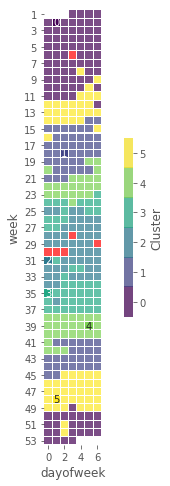

In [17]:
cmap = plt.get_cmap('viridis', n_clusters)

# set color for extreme days (use vmax in heatmap to make this work)
cmap.set_over('r')

# gridspec_kw={'width_ratios' :[10, 1]}
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(
    weekly_df, 
    cmap=cmap, vmin=0, vmax=n_clusters-1, 
    linecolor='w', linewidths=0.01, square=True,
    alpha=0.7,
    cbar_kws={'fraction' :0.02}, ax=ax
)

sns.heatmap(
    weekly_df.where(weekly_repr_df==1),         
    cmap=cmap, vmin=0, vmax=n_clusters-1,         
    linecolor='w', linewidths=0.01, square=True,        
    alpha=1,        
    annot=True,        
    cbar=None
)

cbar = ax.collections[0].colorbar
cbar.set_ticks((np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters)
cbar.set_ticklabels(range(n_clusters))
cbar.set_label('Cluster');

ax.set_yticklabels(ax.get_yticklabels(), rotation='horizontal')
ax.set_facecolor('white')

# _filename = output_prefix + 'calendar.png'
# fig.savefig(graphs_path / _filename, dpi=400)

### Plot LDC

In [18]:
# get dataframe with days (days as columns, time/measure as rows)

days_df = df.assign(
    date=df.index.date, 
    time=df.index.time
).rename_axis('measure', axis=1) \
    .set_index(['date', 'time']) \
    .stack().unstack(level=0)

In [19]:
# get dataframe of days replaced by their representative day

synth_days_df = pd.concat({d:days_df.iloc[:,day_to_repr_d[d] - 1] 
                           for d in days_df.columns.dayofyear}
                         ).unstack(level=0)

synth_days_df.columns = days_df.columns

display(synth_days_df.stack().unstack(level='measure').sum()/days_df.stack().unstack(level='measure').sum())

measure
cooling        0.972587
heating        0.978674
electricity    1.004483
dtype: float64

In [20]:
# get LDC and synth_LDC
ldc_d = {}
synth_ldc_d = {}

for prop in properties:
    
    ldc_d[prop] = df[prop].sort_values(ascending=False).reset_index(drop=True)
    
    synth_ldc_d[prop] = synth_days_df.xs(prop, level='measure').stack() \
        .sort_values(ascending=False).reset_index(drop=True)

ldc_df = pd.concat(ldc_d.values(), keys=ldc_d.keys(), axis=1)
synth_ldc_df = pd.concat(synth_ldc_d.values(), keys=synth_ldc_d.keys(), axis=1)

# _filename = output_prefix + 'ldc.csv'
# ldc_df.to_csv(output_path / _filename, index=True)

# _filename = output_prefix + 'ldc_clustered.csv'
# synth_ldc_df.to_csv(output_path / _filename, index=True)

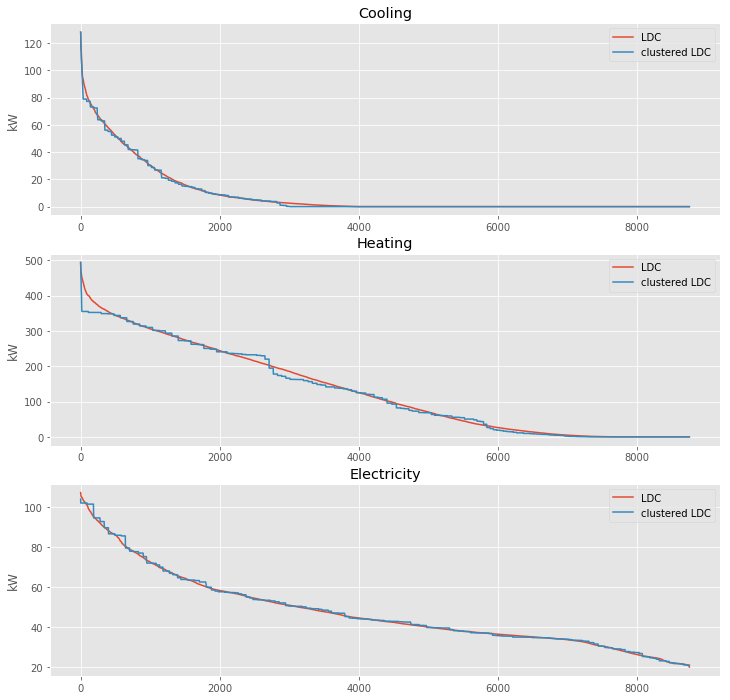

In [21]:
fig, axes = plt.subplots(len(ldc_df.columns), figsize=(12,12))

for i, measure in enumerate(ldc_df.columns):
    
    ldc_df[measure].plot(ax=axes[i], label='LDC')
    synth_ldc_df[measure].plot(ax=axes[i], label='clustered LDC')
    
    axes[i].set_title(measure.title())
    axes[i].legend();
    axes[i].set_ylabel('kW');
    
    # _filename = output_prefix + 'LDC_plot.png'
    # fig.savefig(graphs_path / _filename, dpi=400)